# Setup

In [12]:
import time, os, glob

import torch
torch.manual_seed(0)
import torch.nn as nn
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
from tqdm import tqdm
import copy
import csv

from training.model import *
from training.datasets import *
from inference.heatmap import *

In [20]:
DEBUG = False
TILE_DIR = 'tiles2/'
MODEL_DIR = 'checkpoints/PlaqueTissueClassifier_Epoch_0.pth'
SAVE_PLAQ_DIR = 'outputs/heatmaps/'
TISSUE_PRESENCE_FILE = 'tissue_presence.csv'
# BrainSec
SAVE_IMG_DIR = 'outputs/images/'
SAVE_NP_DIR = 'outputs/numpy/'

IMG_SIZE = 1536
STRIDE = 128
# NOTE: inference loop expects batch size that is <= img size / stride and 
# where img size / batch size is an integer
BATCH_SIZE = IMG_SIZE // STRIDE
NUM_WORKERS = 2

In [3]:
if not os.path.exists(SAVE_PLAQ_DIR):
    os.makedirs(SAVE_PLAQ_DIR)
    
if not os.path.exists(SAVE_IMG_DIR):
        os.makedirs(SAVE_IMG_DIR)
        
if not os.path.exists(SAVE_NP_DIR):
        os.makedirs(SAVE_NP_DIR)

In [14]:
# Retrieve Files
filenames = glob.glob(TILE_DIR + '*')
filenames = [filename.split('/')[-1] for filename in filenames]
filenames = sorted(filenames)
print(filenames)

['Q', 'QQ', 'QQQ', 'RR', 'RRR', 'S', 'SS', 'SSS', 'T', 'TT', 'TTT', 'U', 'UU', 'UUU']


# Inference Pipeline

In [15]:
def saveBrainSegImage(nums, save_dir) :
    """
    Converts 2D array with {0,1,2} into RGB
     to determine different segmentation areas
     and saves image at given directory
    
    Input:
       nums: 2D-NumPy Array containing classification
       save_dir: string indicating save location
    """ 
    
    nums = np.repeat(nums[:,:, np.newaxis], 3, axis=2)
    
    # nums[:,:,0] = RED, nums[:,:,1] = Green, nums[:,:,2] = Blue
    idx_1 = np.where(nums[:,:,0] == 1)  # Index of label 1 (WM)
    idx_2 = np.where(nums[:,:,0] == 2)  # Index of label 2 (GM)

    # For label 0, leave as black color
    # For label 1, set to yellow color: R255G255B0 (WM)
    nums[:,:,0].flat[np.ravel_multi_index(idx_1, nums[:,:,0].shape)] = 255
    nums[:,:,1].flat[np.ravel_multi_index(idx_1, nums[:,:,1].shape)] = 255
    nums[:,:,2].flat[np.ravel_multi_index(idx_1, nums[:,:,2].shape)] = 0
    # For label 2, set to cyan color: R0G255B255 (GM)
    nums[:,:,0].flat[np.ravel_multi_index(idx_2, nums[:,:,0].shape)] = 0
    nums[:,:,1].flat[np.ravel_multi_index(idx_2, nums[:,:,1].shape)] = 255
    nums[:,:,2].flat[np.ravel_multi_index(idx_2, nums[:,:,2].shape)] = 255

    nums = nums.astype(np.uint8) # PIL save only accepts uint8 {0,..,255}
    save_img = Image.fromarray(nums, 'RGB')
    save_img.save(save_dir)
    print("Saved at: " + save_dir)
    

In [16]:
model = PlaqueTissueClassifier().to('cpu')
checkpoint = torch.load(MODEL_DIR, map_location=torch.device('cpu'))

new_state_dict = dict()
for k, v in checkpoint['model_state_dict'].items():
    name = k.replace('module.', '') # remove `module.`
    new_state_dict[name] = v
model.load_state_dict(new_state_dict)

/Users/oliviashen/anaconda3/envs/brainsec/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/var/folders/vv/h0r8fh9j6mz7xx31k0zb32hr0000gn/T/ipykernel_53826/2871139323.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializ

<All keys matched successfully>

Only process the first 2 files to test.

In [21]:
filenames = filenames[0:1]

In [22]:
import time
# Inference Loop:

for slidename in filenames[:]:
    print("Now processing: ", slidename)
    # Read tissue presence map into list
    with open(os.path.join(TILE_DIR, slidename, TISSUE_PRESENCE_FILE), newline='') as f:
        tissue_is_present = list(csv.reader(f, quoting=csv.QUOTE_NONNUMERIC))

    row_nums = (len(tissue_is_present))
    col_nums = len(tissue_is_present[0])   
    
    # Initialize outputs accordingly:
    heatmap_res = IMG_SIZE // STRIDE
    plaque_output = np.zeros((3, heatmap_res*row_nums, heatmap_res*col_nums))
    seg_output = np.zeros((heatmap_res*row_nums, heatmap_res*col_nums), dtype=np.uint8)

    # set model to evaluation mode
    model.eval()
    start_time = time.perf_counter() # To evaluate Time taken per inference

    if DEBUG:
        row_range = [3, 4]
        col_range = [7, 8, 9]
    else:
        row_range = range(row_nums)
        col_range = range(col_nums)

    for row in row_range:
        for col in col_range:
            print(f"Tile ({row},{col})")
            # if tile has no tissue, skip
            if not tissue_is_present[row][col]:
                print("No tissue. Skipping.")
                continue
            print("Contains tissue.")
            # Load tile with padding into dataset
            image_datasets = HeatmapDataset(os.path.join(TILE_DIR, slidename, '0'), row, col, stride=STRIDE)
            dataloader = torch.utils.data.DataLoader(image_datasets, batch_size=BATCH_SIZE,
                                                 shuffle=False, num_workers=NUM_WORKERS)
            
            running_plaques = torch.Tensor(0)
            # create numpy array of heatmap
            output_class = np.zeros((heatmap_res, heatmap_res), dtype=np.uint8)
            
            for idx, data in enumerate(dataloader):
                # get plaque and tissue outputs
                p_out, t_out = model(data)
                # binarize output of plaque prediction and save
                p_preds = (torch.nn.functional.sigmoid(p_out.data) > 0.5)
                running_plaques = torch.cat([running_plaques, p_preds])
                _, t_preds = torch.max(t_out.data, 1)
                i = (idx // (heatmap_res//BATCH_SIZE))
                j = (idx % (heatmap_res//BATCH_SIZE))
                output_class[i,j*BATCH_SIZE:(j+1)*BATCH_SIZE] = t_preds.data
        
            # Final Outputs of Brain Segmentation
            seg_output[row*heatmap_res:(row+1)*heatmap_res, col*heatmap_res:(col+1)*heatmap_res] = output_class
            
            # Final Outputs of Plaque Detection:
            cored = np.asarray(running_plaques[:,0]).reshape(IMG_SIZE//STRIDE,IMG_SIZE//STRIDE)
            diffuse = np.asarray(running_plaques[:,1]).reshape(IMG_SIZE//STRIDE,IMG_SIZE//STRIDE)
            caa = np.asarray(running_plaques[:,2]).reshape(IMG_SIZE//STRIDE,IMG_SIZE//STRIDE)
            
            plaque_output[0, row*heatmap_res:(row+1)*heatmap_res, col*heatmap_res:(col+1)*heatmap_res] = cored
            plaque_output[1, row*heatmap_res:(row+1)*heatmap_res, col*heatmap_res:(col+1)*heatmap_res] = diffuse
            plaque_output[2, row*heatmap_res:(row+1)*heatmap_res, col*heatmap_res:(col+1)*heatmap_res] = caa

            seg_output[row*heatmap_res:(row+1)*heatmap_res, col*heatmap_res:(col+1)*heatmap_res] = output_class

    # Saving Confidence=[0,1] for Plaque Detection
    np.save(os.path.join(SAVE_PLAQ_DIR, slidename), plaque_output)
    
    # Saving BrainSeg Classification={0,1,2}
    np.save(os.path.join(SAVE_NP_DIR, slidename), seg_output)
    saveBrainSegImage(seg_output, os.path.join(SAVE_IMG_DIR, slidename + '.png'))
    
    # Time Statistics for Inference
    end_time = time.perf_counter()
    print("Time to process " + slidename + ": ", end_time-start_time, "sec")

Now processing:  Q
Tile (0,0)
No tissue. Skipping.
Tile (0,1)
No tissue. Skipping.
Tile (0,2)
No tissue. Skipping.
Tile (0,3)
No tissue. Skipping.
Tile (0,4)
No tissue. Skipping.
Tile (0,5)
No tissue. Skipping.
Tile (0,6)
No tissue. Skipping.
Tile (0,7)
No tissue. Skipping.
Tile (0,8)
No tissue. Skipping.
Tile (0,9)
No tissue. Skipping.
Tile (0,10)
No tissue. Skipping.
Tile (0,11)
No tissue. Skipping.
Tile (0,12)
No tissue. Skipping.
Tile (0,13)
No tissue. Skipping.
Tile (0,14)
No tissue. Skipping.
Tile (0,15)
No tissue. Skipping.
Tile (0,16)
No tissue. Skipping.
Tile (0,17)
No tissue. Skipping.
Tile (0,18)
No tissue. Skipping.
Tile (0,19)
No tissue. Skipping.
Tile (0,20)
No tissue. Skipping.
Tile (0,21)
No tissue. Skipping.
Tile (0,22)
No tissue. Skipping.
Tile (0,23)
No tissue. Skipping.
Tile (0,24)
No tissue. Skipping.
Tile (0,25)
No tissue. Skipping.
Tile (0,26)
Contains tissue.


/var/folders/vv/h0r8fh9j6mz7xx31k0zb32hr0000gn/T/ipykernel_53826/1132403141.py:55: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  output_class[i,j*BATCH_SIZE:(j+1)*BATCH_SIZE] = t_preds.data


Tile (0,27)
No tissue. Skipping.
Tile (0,28)
No tissue. Skipping.
Tile (0,29)
No tissue. Skipping.
Tile (0,30)
No tissue. Skipping.
Tile (0,31)
No tissue. Skipping.
Tile (1,0)
No tissue. Skipping.
Tile (1,1)
No tissue. Skipping.
Tile (1,2)
No tissue. Skipping.
Tile (1,3)
No tissue. Skipping.
Tile (1,4)
No tissue. Skipping.
Tile (1,5)
No tissue. Skipping.
Tile (1,6)
No tissue. Skipping.
Tile (1,7)
No tissue. Skipping.
Tile (1,8)
No tissue. Skipping.
Tile (1,9)
No tissue. Skipping.
Tile (1,10)
No tissue. Skipping.
Tile (1,11)
No tissue. Skipping.
Tile (1,12)
No tissue. Skipping.
Tile (1,13)
Contains tissue.
Tile (1,14)
Contains tissue.
Tile (1,15)
Contains tissue.
Tile (1,16)
Contains tissue.
Tile (1,17)
Contains tissue.
Tile (1,18)
No tissue. Skipping.
Tile (1,19)
No tissue. Skipping.
Tile (1,20)
No tissue. Skipping.
Tile (1,21)
No tissue. Skipping.
Tile (1,22)
No tissue. Skipping.
Tile (1,23)
No tissue. Skipping.
Tile (1,24)
No tissue. Skipping.
Tile (1,25)
No tissue. Skipping.
Tile (1

In [11]:
def plot_heatmap(final_output) :
    """
    Plots Confidence Heatmap of Plaques = [0,1]
    
    Inputs:
        final_output (NumPy array of 
        3*img_height*height_width) :
            Contains Plaque Confidence with each axis
            representing different types of plaque
            
    Outputs:
        Subplots containing Plaque Confidences
    """
    fig = plt.figure(figsize=(45,15))

    ax = fig.add_subplot(311)

    im = ax.imshow(final_output[0], cmap=plt.cm.get_cmap('viridis', 20), vmin=0, vmax=1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, ticks=[0.0, 0.25, 0.5, 0.75, 1.0])

    ax = fig.add_subplot(312)

    im = ax.imshow(final_output[1], cmap=plt.cm.get_cmap('viridis', 20), vmin=0, vmax=1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, ticks=[0.0, 0.25, 0.5, 0.75, 1.0])

    ax = fig.add_subplot(313)

    im = ax.imshow(final_output[2], cmap=plt.cm.get_cmap('viridis', 20), vmin=0, vmax=1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, ticks=[0.0, 0.25, 0.5, 0.75, 1.0])

/var/folders/vv/h0r8fh9j6mz7xx31k0zb32hr0000gn/T/ipykernel_53826/183819601.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  im = ax.imshow(final_output[0], cmap=plt.cm.get_cmap('viridis', 20), vmin=0, vmax=1)
/var/folders/vv/h0r8fh9j6mz7xx31k0zb32hr0000gn/T/ipykernel_53826/183819601.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  im = ax.imshow(final_output[1], cmap=plt.cm.get_cmap('viridis', 20), vmin=0, vmax=1)
/var/folders/vv/h0r8fh9j6mz7xx31k0zb32hr0000gn/T/ipykernel_53826/183819601.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.color

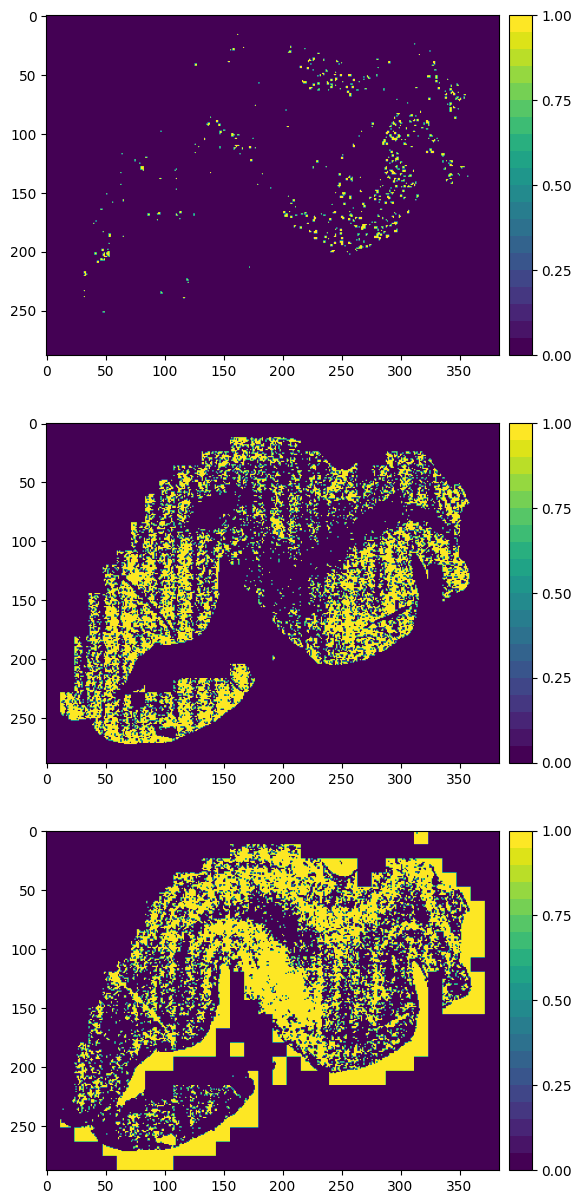

In [24]:
plot_heatmap(plaque_output)

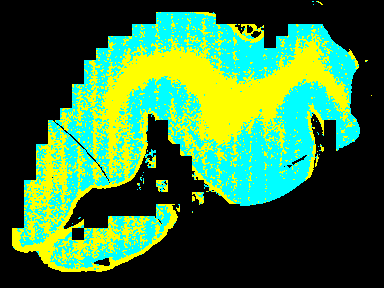

In [27]:
from IPython.display import display
tissue_seg_img = Image.open(os.path.join(SAVE_IMG_DIR, filenames[0] + ".png"))
display(tissue_seg_img)

# Post Processing